In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np

### **LOADING THE FINAL DENGUE-CLIMATE DATASET**

This section loads the merged dataset that contains dengue cases per barangay-week, along with climate variables such as temperature, humidity, and precipitation. We perform initial data diagnostics to inspect dimensions, data types, missing values, and basic descriptive statistics.

In [2]:
df = pd.read_csv("../data/processed/dengue_climate_all_years.csv")
df["Population"] = (
    df["Population"]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
)

print("Shape:")
print(df.shape)

print("\nInfo:")
print(df.info())

print("\nNull Values:")
print(df.isna().sum())

print("\nBasic Stats:")
display(df.describe())

Shape:
(29680, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29680 entries, 0 to 29679
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Barangay       29680 non-null  object 
 1   Cases          29680 non-null  int64  
 2   Humidity       29680 non-null  float64
 3   Precipitation  29680 non-null  float64
 4   Temperature    29680 non-null  float64
 5   Week           29680 non-null  int64  
 6   Year           29680 non-null  int64  
 7   Population     29680 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 1.8+ MB
None

Null Values:
Barangay         0
Cases            0
Humidity         0
Precipitation    0
Temperature      0
Week             0
Year             0
Population       0
dtype: int64

Basic Stats:


,Cases,Humidity,Precipitation,Temperature,Week,Year,Population
count,29680.000000,29680.000000,29680.000000,29680.000000,29680.000000,29680.000000,29680.000000
mean,0.469980,82.246264,3.705584,26.943856,27.000000,2021.000000,9105.025000
std,1.407614,2.031009,4.445041,0.440780,15.297316,2.000034,14168.627179
min,0.000000,72.302770,0.000000,24.481775,1.000000,2018.000000,17.000000
25%,0.000000,82.371367,0.000000,26.961359,14.000000,2019.000000,426.000000
50%,0.000000,82.775006,1.865025,27.049707,27.000000,2021.000000,1671.000000
75%,0.000000,82.775006,6.486822,27.049707,40.000000,2023.000000,13378.250000
max,32.000000,87.772452,29.218271,27.993662,53.000000,2024.000000,77756.000000


### **POPULATION TOTALS AND DISTRIBUTIONS**

Exploring population size and distribution across Cagayan de Oro City barangays:

- Total population per barangay (2020 census)
- Top barangays by population size
- Overall distribution of barangay populations

These visualizations provide context on population concentration across barangays and support fair interpretation of dengue incidence by accounting for differences in population size.

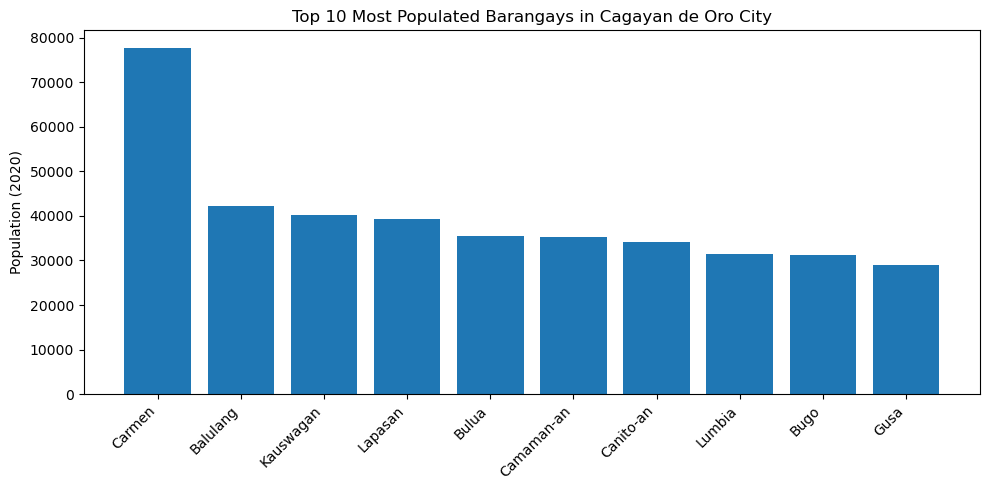

In [3]:
pop_by_barangay = (
    df[['Barangay', 'Population']]
    .drop_duplicates(subset='Barangay')
)

top10 = (
    pop_by_barangay
    .sort_values(by='Population', ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
plt.bar(top10['Barangay'], top10['Population'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Population (2020)')
plt.title('Top 10 Most Populated Barangays in Cagayan de Oro City')
plt.tight_layout()
plt.show()

### **DENGUE CASE TOTALS AND DISTRIBUTIONS**

Exploring dengue trends and totals:

- Total cases per year
- Total cases per barangay
- Overall distribution of weekly dengue cases

These visualizations help identify high-incidence years and barangays.

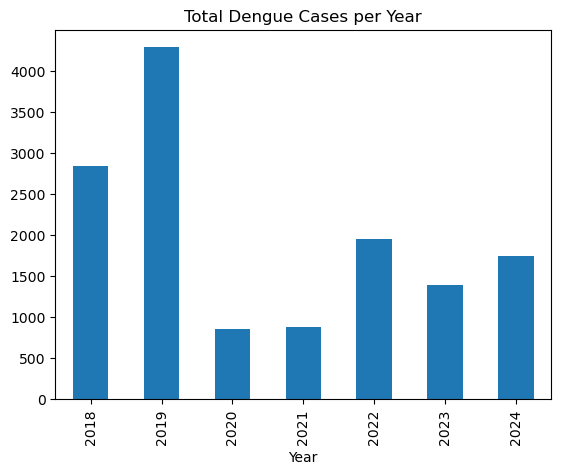

In [4]:
df.groupby("Year")["Cases"].sum().plot(kind="bar", title="Total Dengue Cases per Year")
plt.show()

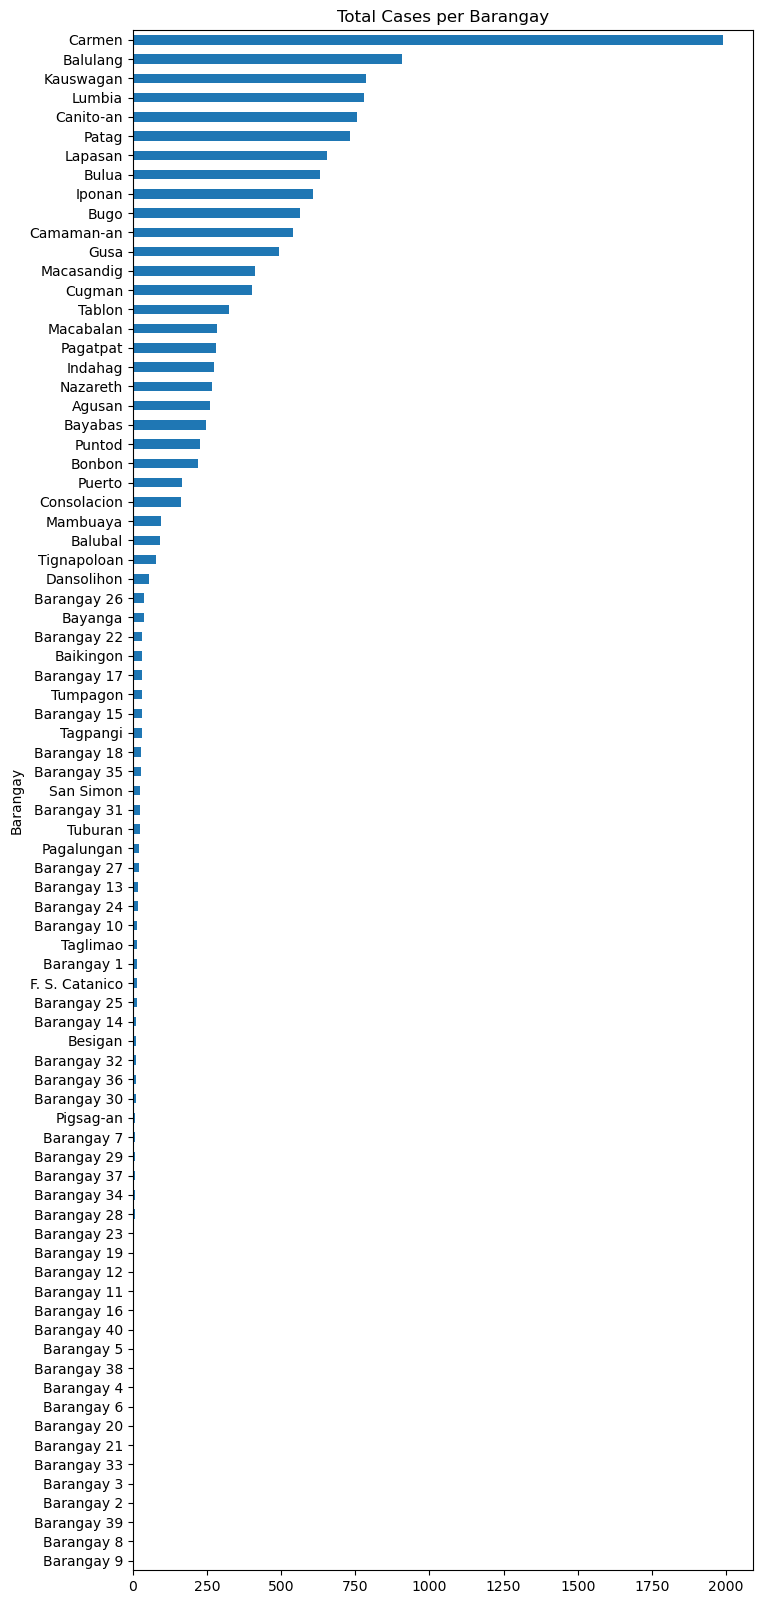

In [5]:
df.groupby("Barangay")["Cases"].sum().sort_values().plot(
    kind="barh",
    title="Total Cases per Barangay",
    figsize=(8, 20)
)
plt.show()

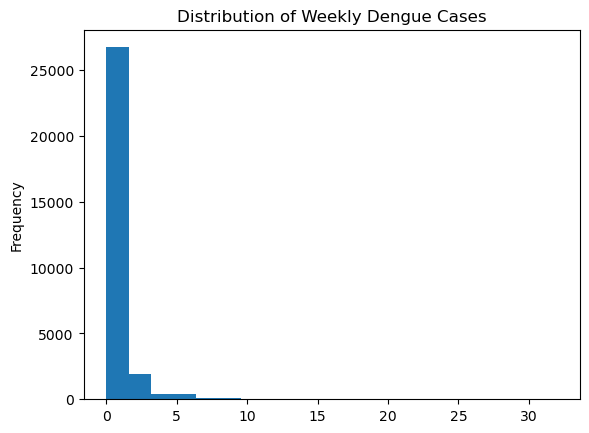

In [6]:
df["Cases"].plot(kind="hist", bins=20, title="Distribution of Weekly Dengue Cases")
plt.show()

### **SEASONALITY ANALYSIS: AVERAGE MONTHLY CASES**

This plot highlights seasonal dengue trends by showing the average number of cases per week across all barangays and years.
Spikes may indicate periods of higher dengue transmission risk.

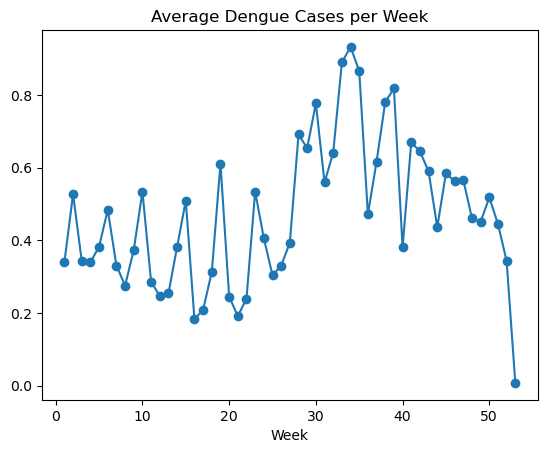

In [7]:
df.groupby("Week")["Cases"].mean().plot(kind="line", marker="o", title="Average Dengue Cases per Week")
plt.show()

### **CLIMATE CORRELATION AND RELATIONSHIPS**

This section examines relationships between dengue cases and key climate variables.

We use:

- A heatmap for correlation coefficients
- Scatter plots for pairwise visual relationships between cases and each climate factor.

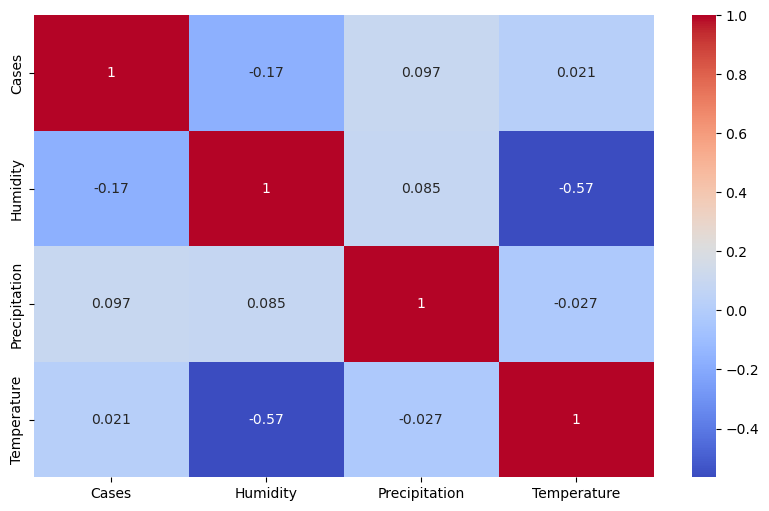

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[["Cases", "Humidity", "Precipitation", "Temperature"]].corr(), 
            annot=True, cmap="coolwarm")

plt.show()

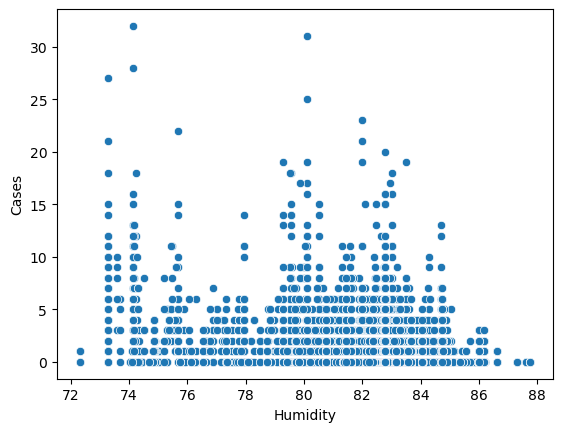

In [9]:
sns.scatterplot(data=df, x="Humidity", y="Cases")
plt.show()

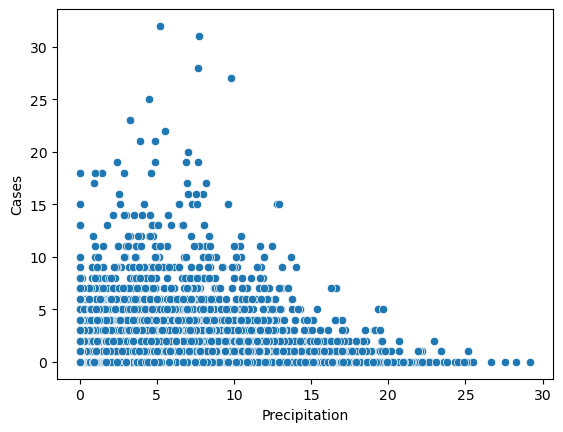

In [10]:
sns.scatterplot(data=df, x="Precipitation", y="Cases")
plt.show()

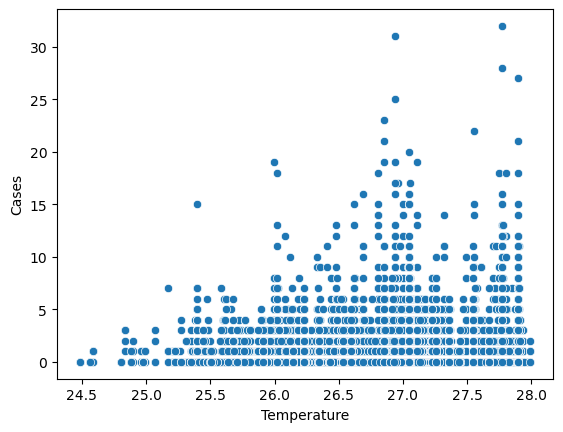

In [11]:
sns.scatterplot(data=df, x="Temperature", y="Cases")
plt.show()

### **DENGUE CASES OVER TIME**

We create a time series plot of total dengue cases aggregated across all barangays. This visualization provides a long-term perspective on case fluctuations over time.

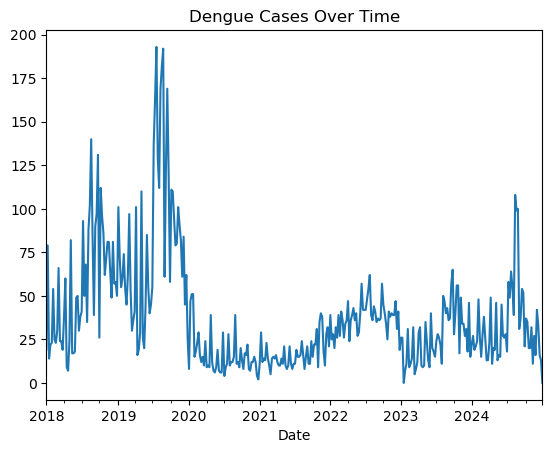

In [12]:
# Create a 'Date' column based on year and week number (ISO format)
df["Date"] = pd.to_datetime(df["Year"].astype(str) + df["Week"].astype(str).str.zfill(2) + '1', format='%G%V%u')
cases_over_time = df.groupby("Date")["Cases"].sum()
cases_over_time.plot(title="Dengue Cases Over Time")
plt.show()

### **OUTLIER DETECTION BY BARANGAY**

We use a boxplot to detect barangays with unusually high or low dengue case counts. Outliers may represent hotspots that require further analysis or verification.

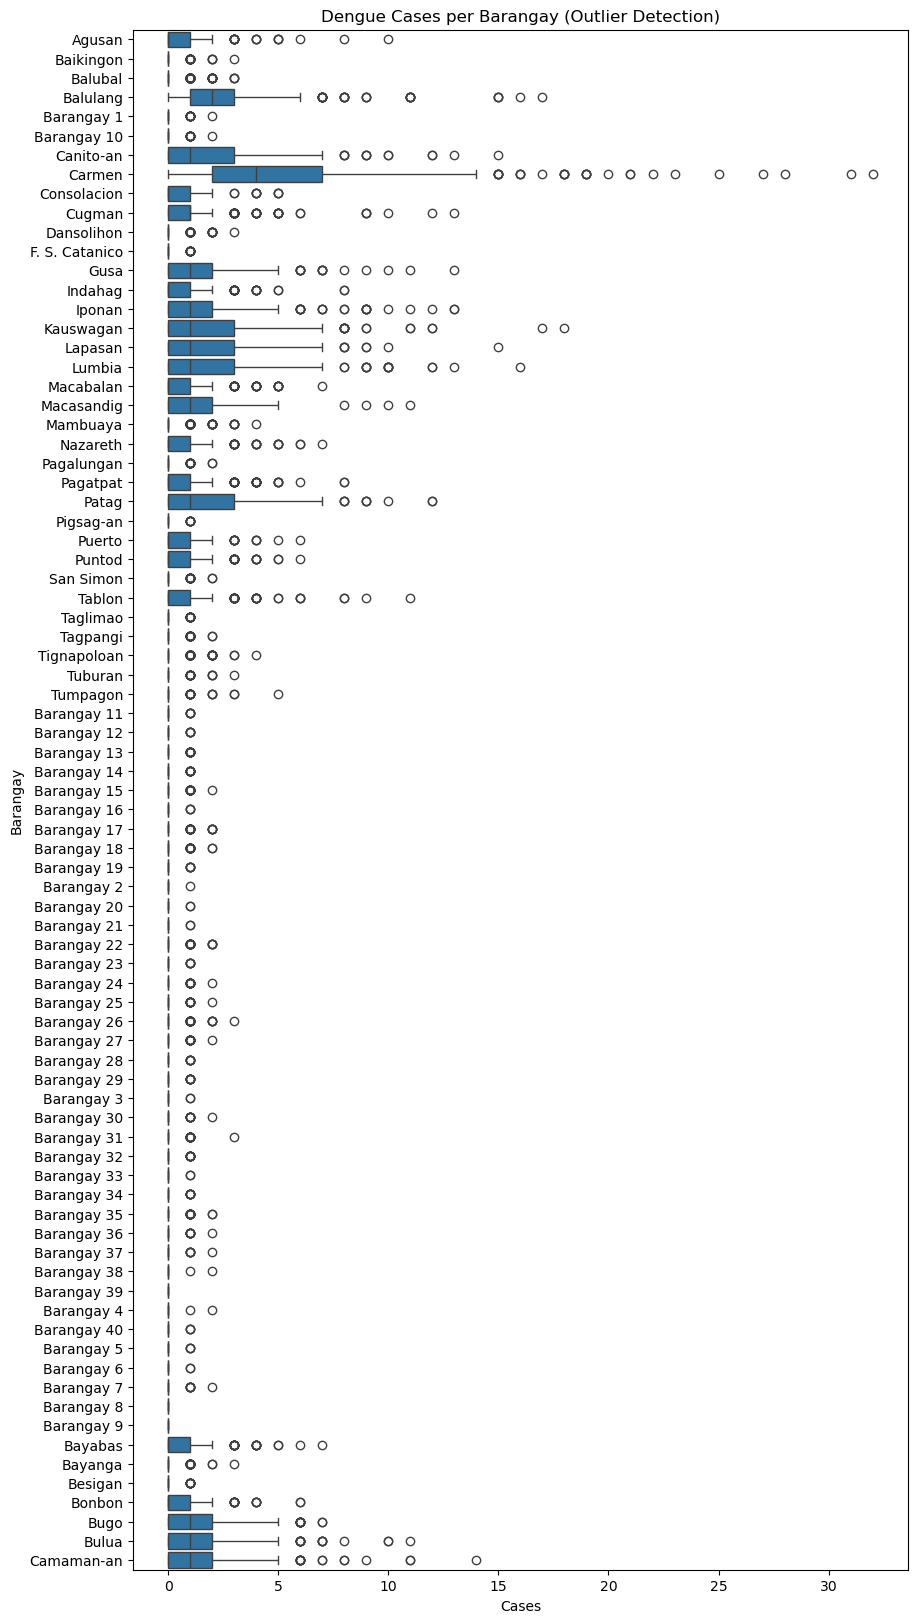

In [13]:
plt.figure(figsize=(10, 20))
sns.boxplot(data=df, x="Cases", y="Barangay")
plt.title("Dengue Cases per Barangay (Outlier Detection)")
plt.show()

### **PAIRWISE FEATURE RELATIONSHIPS**

A pairplot helps visualize the joint distributions and linearity between dengue cases and climate features (humidity, precipitation, temperature).
This supports multivariate relationship analysis before modeling.

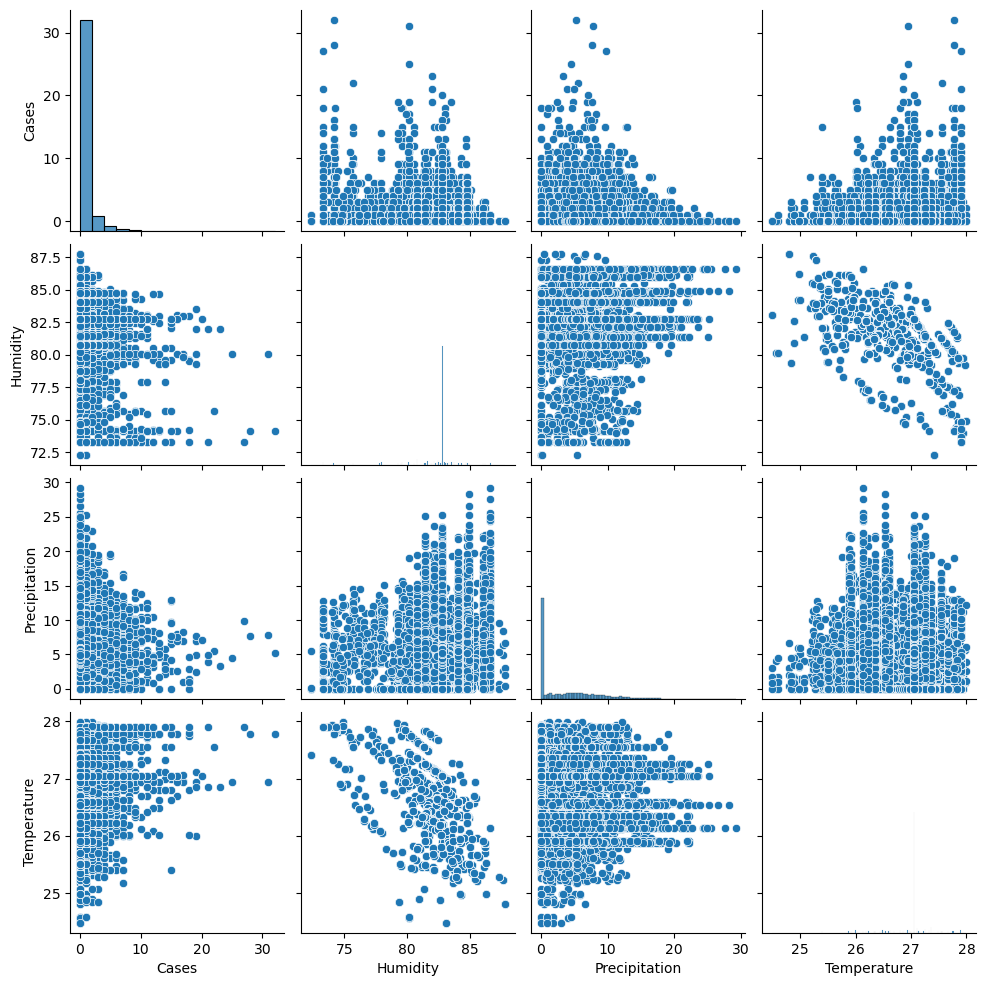

In [14]:
sns.pairplot(df[["Cases", "Humidity", "Precipitation", "Temperature"]])
plt.show()

### **TEMPORAL DEPENDENCE AND STATIONARITY CHECK**

Before modeling dengue cases, it is important to assess both **temporal dependence** and **stationarity** of the time series.

- **Stationarity Check:** We applied the Augmented Dickey-Fuller (ADF) test to determine if the weekly dengue cases series is stationary. The original series was borderline stationary, while the log-differenced series was strongly stationary. Stationarity is a key assumption for time series models like ARIMA or VARMAX, ensuring consistent mean and variance over time.

- **Autocorrelation Function (ACF):** Measures correlation between cases across different lags.  
- **Partial Autocorrelation Function (PACF):** Isolates the direct correlation at each lag, helping identify the most relevant lagged relationships.

Combining these analyses allows us to **understand temporal dependencies** and select appropriate lag orders for time series forecasting models.

In [15]:
# Sort and Aggregate
df = df.sort_values("Date")
weekly_cases = df.groupby("Date")["Cases"].sum()
weekly_cases.index = pd.to_datetime(weekly_cases.index)

<Figure size 1200x500 with 0 Axes>

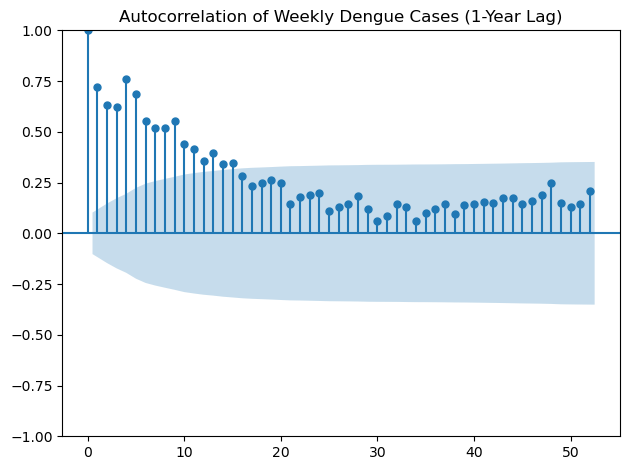

In [16]:
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plot_acf(weekly_cases, lags=52)
plt.title("Autocorrelation of Weekly Dengue Cases (1-Year Lag)")
plt.tight_layout()
plt.show()

In [17]:
# Augmented Dickey-Fuller Test (Original Series)
adf_result = adfuller(weekly_cases)
print("ADF Statistic (Original Series):", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic (Original Series): -2.986878398320202
p-value: 0.03613809609530882
Critical Value 1%: -3.449226932880019
Critical Value 5%: -2.869857365438656
Critical Value 10%: -2.571201085130664


**Original Series:**

* **ADF Statistic:** -2.987
* **p-value:** 0.036
* **Critical Values:** 1% = -3.449, 5% = -2.870, 10% = -2.571

**Interpretation:**

* The p-value is below 0.05, allowing us to reject the null hypothesis of a unit root at the 5% significance level.
* This indicates that the **original series is stationary**, though it may still exhibit minor short-term fluctuations.

**Log-Differenced Series:**

* **ADF Statistic:** -6.632
* **p-value:** 5.69e-09
* **Critical Values:** 1% = -3.449, 5% = -2.870, 10% = -2.571

**Interpretation:**

* The ADF statistic is far below all critical values, confirming strong stationarity.
* However, since the original series already satisfies stationarity requirements, differencing is unnecessary.

**Conclusion:**

* We **accept that the original series is sufficiently stationary** and will use it directly for time series modeling (e.g., ARIMA, VARMAX).
* Using the original series preserves the natural scale of the data and avoids potential over-differencing, which could distort relationships among variables.